# Analyzing the Danceability of a Song on Spotify based on its Valence, Energy, Tempo, and Mode
Group 79: Steve (Zefan) Liu, Zeen Lin, Erin Lau, Eric Shuai

<em>Word Count: 495</em>

<h2 style="color:#008a05">Introduction</h2>

After three long years of pandemic-styled living, the desire to return to the party-scene has cultivated a spark of excitement in communities worldwide[¹](https://www.npr.org/2021/04/17/987865318/life-in-the-roaring-2020s-young-people-prepare-to-party-reclaim-lost-pandemic-ye). To prepare for this upcoming age of buzz and festivities, it is essential for venues, DJ’s, and rising artists to consider the features of their music that increase the likelihood of dancing and fun. Thus, through this project, our group aims to predict the danceability of an unknown song given multiple characteristics—the tempo, energy, valence, and mode—of a song.

**Question:** What would the danceability of a song be given its tempo, energy, valence, and mode?

For this analysis, we will be using the **[Spotify Audio Features dataset](https://www.kaggle.com/datasets/tomigelo/spotify-audio-features)** (<https://www.kaggle.com/datasets/tomigelo/spotify-audio-features>) captured from April 2019 by the user *tomigelo*. This dataset was scraped via Spotify API and Python and consists of variables of audio features (e.g. acousticness, song length, key, etc.) provided by Spotify[²]() pertaining to a given song.

*¹ <https://www.npr.org/2021/04/17/987865318/life-in-the-roaring-2020s-young-people-prepare-to-party-reclaim-lost-pandemic-ye>
<br>² <https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features>*

<h2 style="color:#008a05">Preliminary Exploratory Data Analysis</h2>

### Loading Libraries, Reading Data

In [1]:
# --- Setting up prerequisites libraries ---
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 8)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# --- Load the data from the web into R ---
dataset_url <- "https://github.com/eshuaiii/dsci-100-2022w1-group-79/raw/main/data/SpotifyAudioFeaturesApril2019.csv"

# read dataset from URL
spotify_big <- read_csv(url(dataset_url))

# read the first 5 rows
head(spotify_big, 5)

Rows: 130663 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): artist_name, track_id, track_name
dbl (14): acousticness, danceability, duration_ms, energy, instrumentalness,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",5.82e-03,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,15
YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),2.44e-02,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,0
R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,2.50e-02,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,56
Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,2.94e-02,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,0
Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,3.52e-05,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,0


### Sampling and creating tidy data

In [31]:
# --- Extract a sample of size 500 from the original data as our training data ---
set.seed(79)
raw_spotify <- spotify_big |>
    sample_n(2079) |>
    select(danceability, energy, tempo, valence, mode)

In [32]:
spotify_split <- initial_split(raw_spotify, prop = 0.79, strata = danceability)
spotify_training <- training(spotify_split)
spotify_testing <- testing(spotify_split)

spotify_training

danceability,energy,tempo,valence,mode
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.432,0.597,104.448,0.203,1
0.235,0.866,177.265,0.338,1
0.391,0.403,135.935,0.157,1
0.311,0.084,106.178,0.131,1
⋮,⋮,⋮,⋮,⋮
0.897,0.459,135.901,0.706,1
0.810,0.662,123.011,0.800,1
0.822,0.532,125.015,0.312,0
0.784,0.539,140.023,0.358,0


In [40]:
# --- Clean and wrangle our training data into a tidy format ---
    # due to the range of different predictors, we rescaled "energy", "tempo", and "valence"
    # and transformed "mode" into the factor type as it only has two levels

# !!! show tempo graph, realize that 0 cannot work, redo analysis and show graphs.

spotify_training_cleaned <- spotify_training |>
                filter(tempo != 0) |>
                mutate(energy = as.numeric(scale(energy)),
                       tempo = as.numeric(scale(tempo)),
                       valence = as.numeric(scale(valence)),
                       mode = as_factor(mode))
head(spotify_training_cleaned, 5)

danceability,energy,tempo,valence,mode
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.432,0.1158071,-0.5273297,-0.8587920,1
0.235,1.1348156,1.8909626,-0.3358788,1
0.391,-0.6190912,0.5183708,-1.0369698,1
0.311,-1.8275065,-0.4698755,-1.1376790,1
0.438,0.5590190,1.3210032,-0.2158024,0


danceability,energy,tempo,valence,mode
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.432,0.1158071,-0.5273297,-0.8587920,1
0.235,1.1348156,1.8909626,-0.3358788,1
0.391,-0.6190912,0.5183708,-1.0369698,1
0.311,-1.8275065,-0.4698755,-1.1376790,1
⋮,⋮,⋮,⋮,⋮
0.897,-0.4069556,0.51724159,1.0895438,1
0.810,0.3620359,0.08915765,1.4536464,1
0.822,-0.1304217,0.15571159,-0.4365880,0
0.784,-0.1039048,0.65413546,-0.2584102,0


###  Statistical Summary

In [13]:
# !!! write English about summary
# --- An aggregate statistical summary of the training data ---
spotify_training_summary <-  spotify_training_cleaned |>
                             group_by(mode) |>
                             summarize(number_of_observations = n(),
                                       mean_danceability = mean(danceability),
                                       mean_energy = mean(energy),
                                       mean_tempo = mean(tempo),
                                       mean_valence = mean(valence),
                                       sd_danceability = sd(danceability),
                                       sd_energy = sd(energy),
                                       sd_tempo = sd(tempo),
                                       sd_valence = sd(valence))
spotify_training_summary

mode,number_of_observations,mean_danceability,mean_energy,mean_tempo,mean_valence,sd_danceability,sd_energy,sd_tempo,sd_valence
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,638,0.5987279,0.08105143,-0.03854390,-0.01812460,0.1899385,0.9549993,0.9722981,0.9911018
1,1003,0.5635846,-0.05155615,0.02451745,0.01152891,0.1938463,1.0247358,1.0169485,1.0059419


### General Visualizations

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



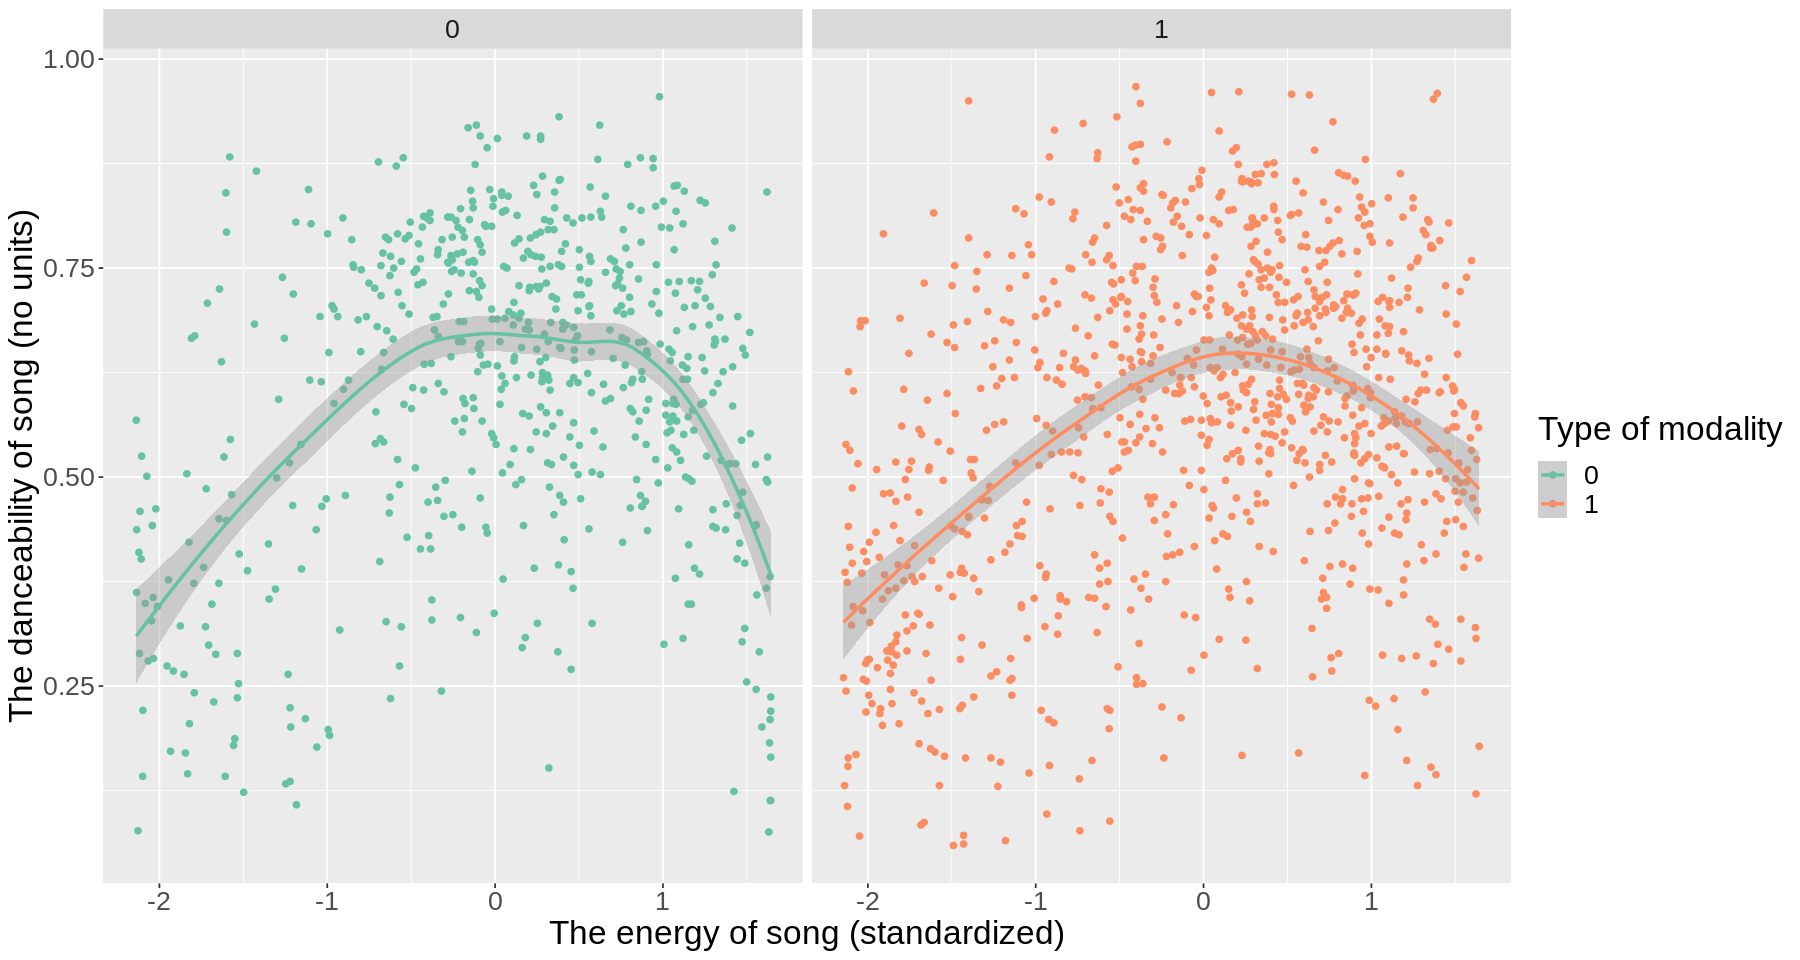

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



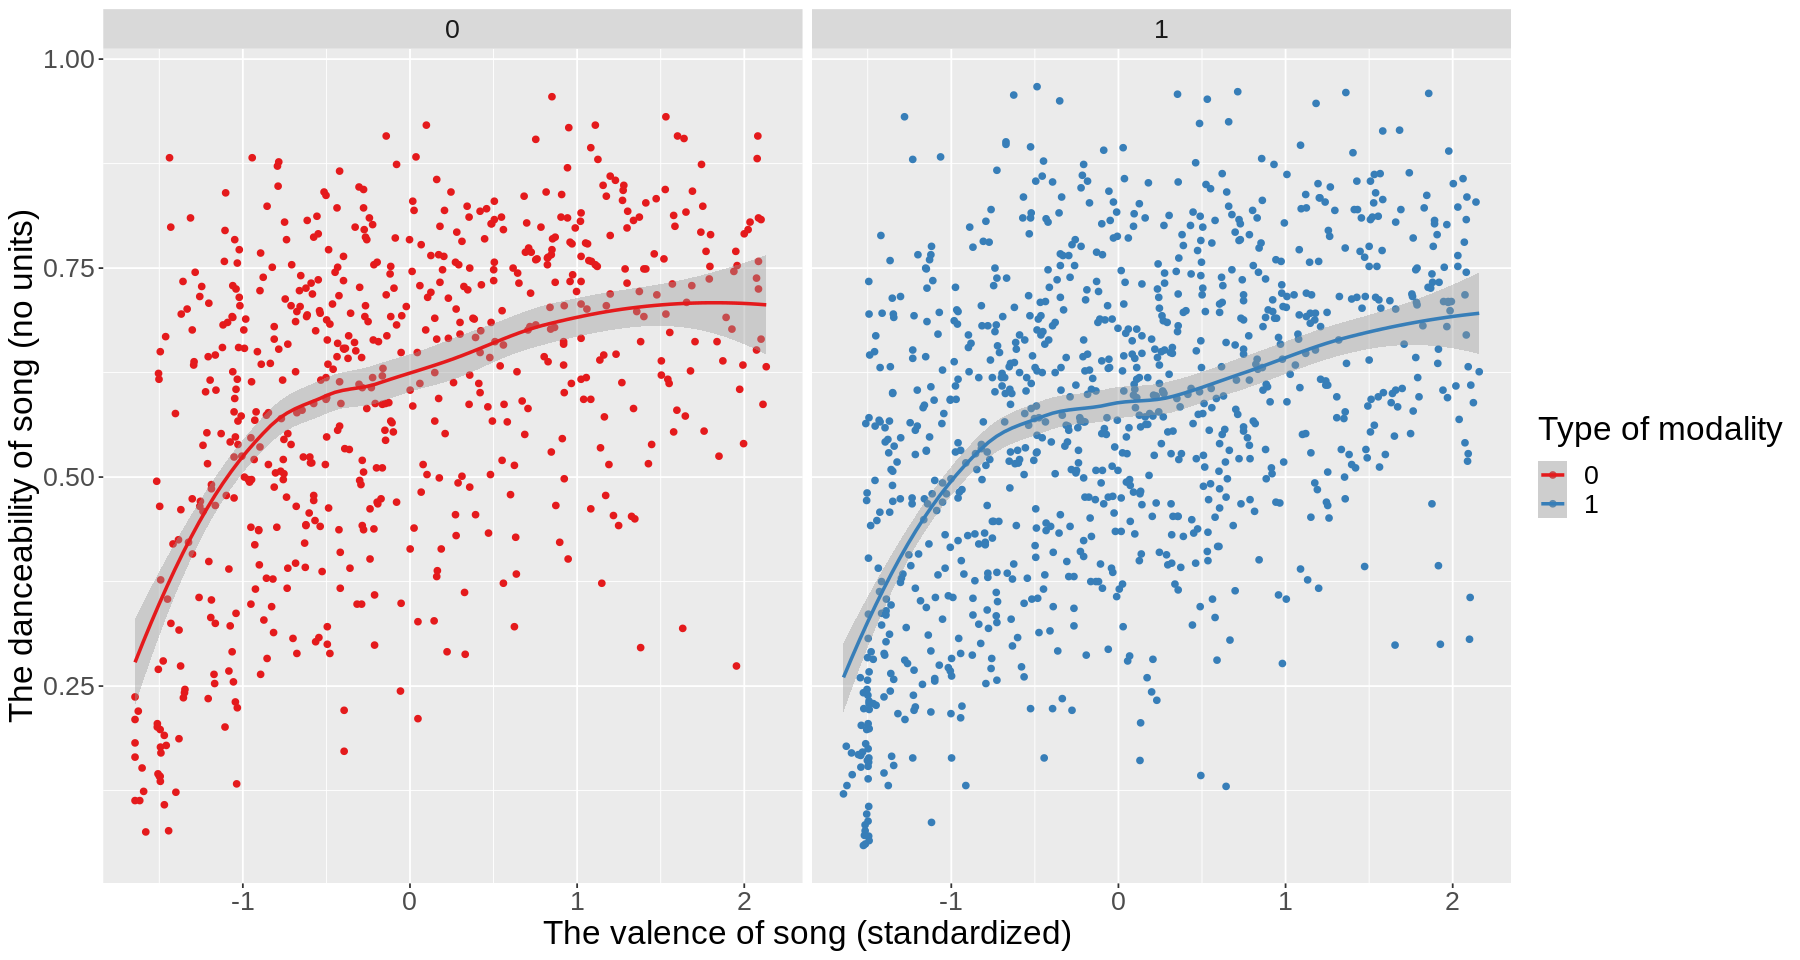

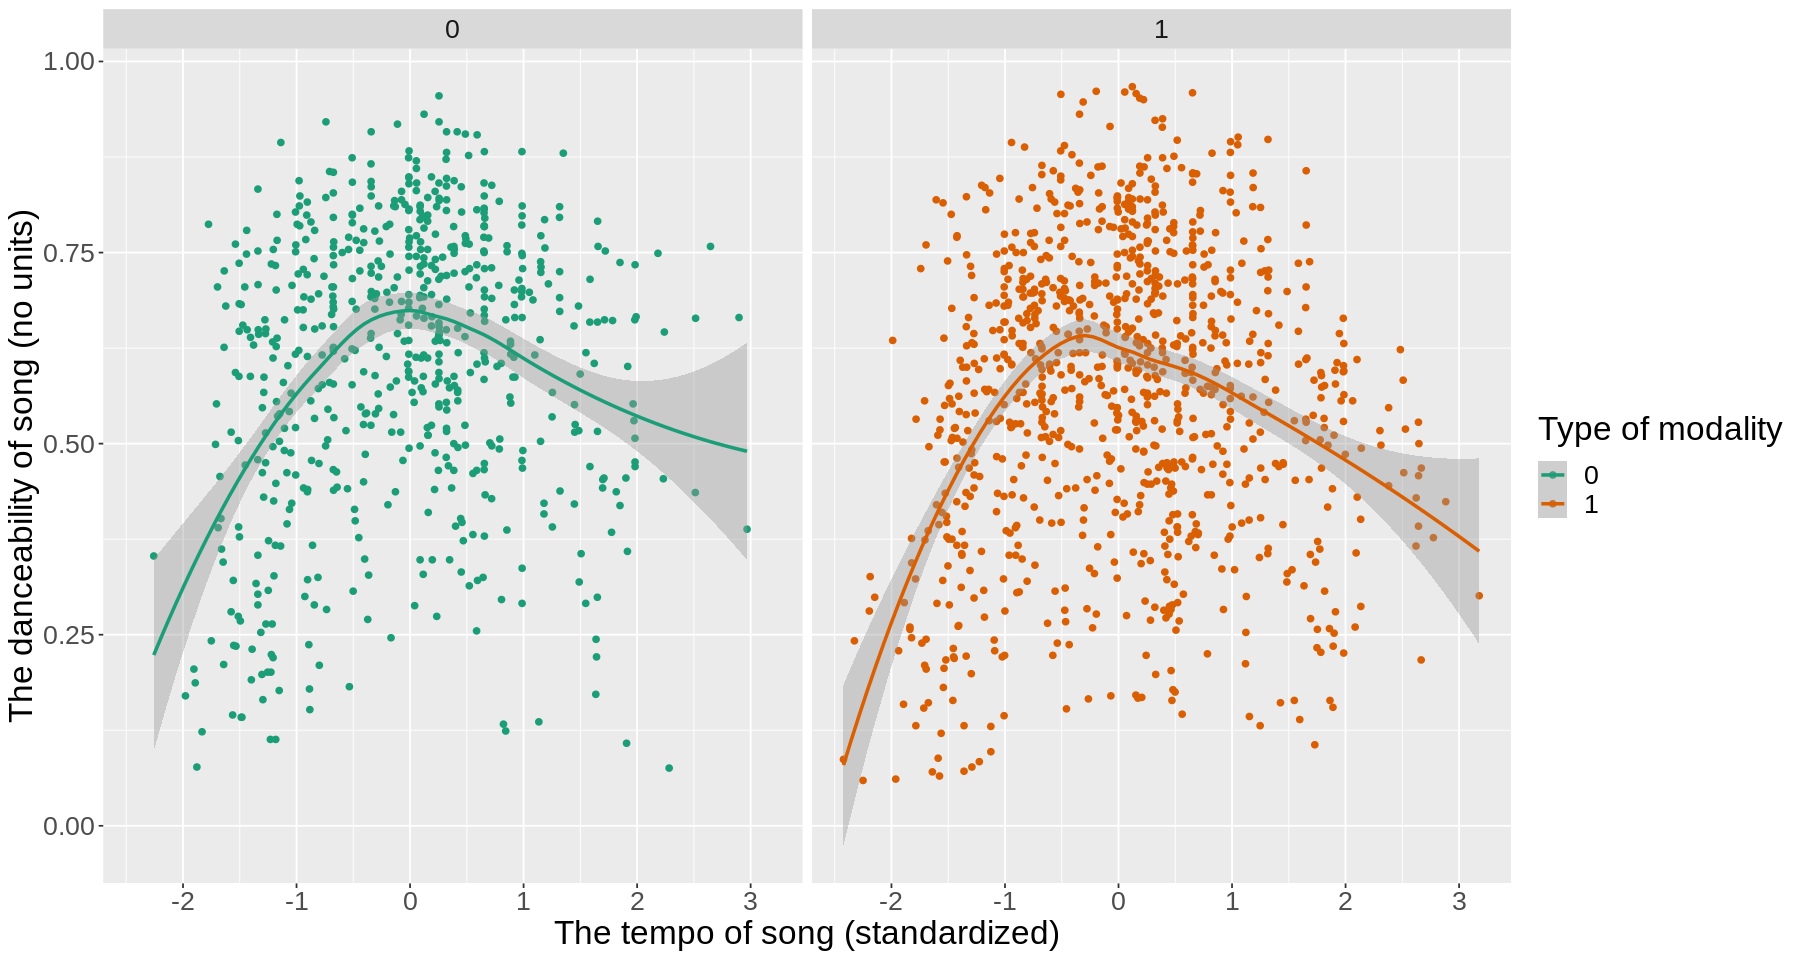

In [41]:
options(repr.plot.width = 15, repr.plot.height = 8)

# Visualize the relationship between danceability and energy, classified by mode
ggplot(spotify_training_cleaned, aes(x = energy, y = danceability, color = mode)) +
    geom_point(alpha = 1.1) +
    geom_smooth()+
    facet_wrap(~mode) +
    labs(x = "The energy of song (standardized)", y = "The danceability of song (no units)", color = "Type of modality") +
    theme(text = element_text(size = 20)) +
    scale_color_brewer(palette = "Set2")

# Visualize the relationship between danceability and valence, classified by mode
ggplot(spotify_training_cleaned, aes(x = valence, y = danceability, color = mode)) +
    geom_point(alpha = 1.1) +
    geom_smooth()+
    facet_wrap(~mode) +
    labs(x = "The valence of song (standardized)", y = "The danceability of song (no units)", color = "Type of modality") +
    theme(text = element_text(size = 20)) +
    scale_color_brewer(palette = "Set1")

# Visualize the relationship between danceability and tempo, classified by mode
ggplot(spotify_training_cleaned, aes(x = tempo, y = danceability, color = mode)) +
    geom_point(alpha = 1.1) +
    geom_smooth()+
    facet_wrap(~mode) +
    labs(x = "The tempo of song (standardized)", y = "The danceability of song (no units)", color = "Type of modality") +
    theme(text = element_text(size = 20)) +
    scale_color_brewer(palette = "Dark2")

In [ ]:
# !!! check if all necessary visualizations + summaries are met

In [ ]:
# Perform k-nn regression algorithm

In [35]:
# DISCUSSION WAO
# !!! talk about how tempo = 0 cannot work; that means either Spotify screwed up or it's not a song
# (e.g. white noise has no tempo and should not be treated)

<h2 style="color:#008a05">Methods</h2>

**<u>Variables used:</u>**

> **Danceability**, `danceability` (0.0-1.0, no units)
>
> **Energy**, `energy` (0.0-1.0, no units)
>
> **Tempo**, `tempo` (dbl, BPM)
>
> **Valence/musical positiveness**, `valence` (0.0-1.0)
>
> **Modality**, `mode` (0.0-1.0)

We will be using the energy, valence, tempo, and mode as predictor variables. Energy and tempo are crucial as they form the rhythmic backbones of a song’s danceability. The valence and mode were selected as a song expressing higher positiveness may influence the listener to dance along, or if the switch of mode can affect the feeling towards a song.

After completing initial cleanup (trimming `N/A` values, selecting, etc.), we first need to proportionally sample the data since the dataset is too large, before splitting it into training/testing data. Next, we perform rectangular k-neighbours regression analysis alongside cross-validation to determine an optimal number of neighbours, $k$, before trying our model against testing data to determine model accuracy. We can then plot multiple scatter plots with danceability against each predictor with the training model average as a line, and a line graph revealing the RMSE against multiple values of $k$.

Finally, we would like to repeat our analysis through linear regression, allowing us to compare the accuracies of both models.


<h2 style="color:#008a05">Expected Outcomes and Significance</h2>

We expect that an appropriate model will be developed to incorporate our predictor variables—valence, mode, tempo, and energy—to predict the danceability of an unknown song. The results of this study could assist musicians who desire to create danceable music according to specific characteristics. This finding could assist them in identifying and selecting danceable features of the song before creating it, thus increasing the likelihood of a successful composition.

Further, this study raises several interesting questions. For instance:
- How do other variables, like a song’s length, its key, or how wordy it is, affect its danceability?
- Is popularity based primarily on how danceable a song is?
- Since the danceability variable, per Spotify, is a combination of factors like beat strength, regularity, and stability, is it an unbiased, objective variable?
- Could the danceability of a song be viewed differently across regions, cultures, and societies?

<br><br><br>
*Thank you! - Group 79*